# Часть 1
CNN на MNIST'е

##Подготовка данных

In [45]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

In [57]:
transform = transforms.Compose(
[transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
shuffle=False, num_workers=2)
classes = tuple(str(i) for i in range(10))

In [ ]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [ ]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

In [47]:
trainloader.dataset.train_data[0]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

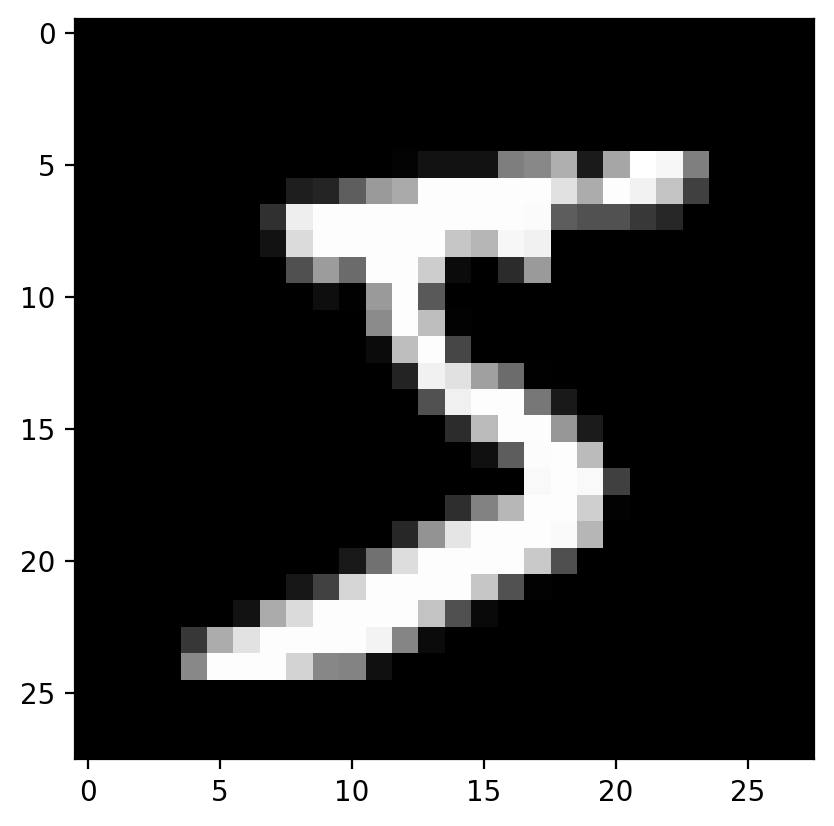

In [48]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()
numpy_img.shape
plt.imshow(numpy_img);
plt.imshow(numpy_img, cmap='gray');


###Функция отрисовки цифры

In [49]:
def printNum(i):
  plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

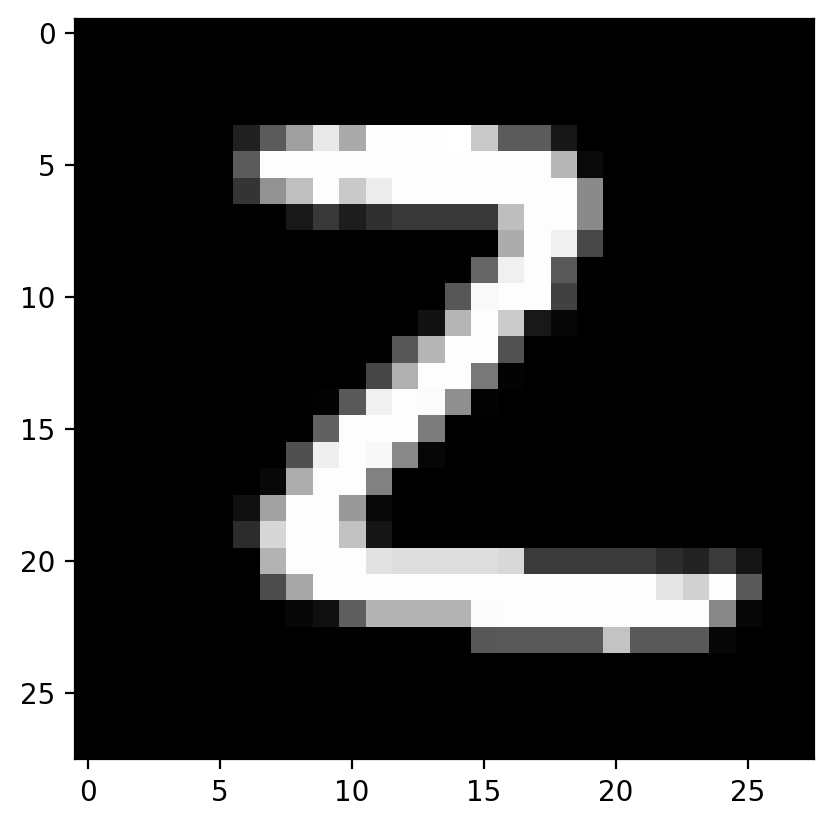

In [50]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)
printNum(i)

In [60]:
for data in trainloader:
  print(len(data))
  print('Images:',data[0].shape)
  print('Labels:', data[1].shape)
  break

2
Images: torch.Size([4, 1, 28, 28])
Labels: torch.Size([4])


##Cверточная нейронная сеть для MNIST

In [53]:
import torch.nn as nn
import torch.nn.functional as F # Functional

In [ ]:
# Заметьте: класс наследуется от nn.Module
class SimpleConvNet(nn.Module):
  def __init__(self):
# вызов конструктора предка
    super(SimpleConvNet, self).__init__()
# необходмо заранее знать, сколько каналов у картинки (сейчас = 1)(черно-белое изображение),
# которую будем подавать в сеть, больше ничего
# про входящие картинки знать не нужно
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(4 * 4 * 16, 120) # !!!
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #print(x.shape)
    #return
    x = x.view(-1, 4 * 4 * 16) # !!! Это – размерность тензора перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Важное примечание: можно заметить, что в строчках с #!!! есть число 4 * 4 * 16.
Это – размерность тензора перед FC-слоями (H x W x C), тут её приходиться высчитывать
вручную (в Keras, например, .Flatten() всё делает за Вас). Однако есть один прием - просто
сделайте в forward() print(x.shape) (закомментированная строка). Вы увидите
размер (batch_size, C, H, W) – нужно перемножить все, кроме первого (batch_size), это и
будет первая размерность Linear(), и именно в C * H * W нужно "развернуть" x перед
подачей в Linear().
То есть нужно будет запустить цикл с обучением первый раз с print() и сделать
после него break, посчитать размер, вписать его в нужные места и стереть print() и break.

torch.Size([4, 16, 4, 4])

###Код обучения слоя

In [ ]:
from tqdm import tqdm_notebook
# объявляем сеть
net = SimpleConvNet()
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()
# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# итерируемся
for epoch in tqdm_notebook(range(3)):
  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)):
    # так получаем текущий батч
    X_batch, y_batch = batch
# обнуляем веса
    optimizer.zero_grad()
    # forward + backward + optimize
    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
# выведем текущий loss
    running_loss += loss.item()
    # выведем качество каждые 2000 батчей
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Обучение закончено')

<ipython-input-12-17b639cc3f97>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(3)):


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-12-17b639cc3f97>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.038
[1,  4000] loss: 0.422
[1,  6000] loss: 0.321
[1,  8000] loss: 0.264
[1, 10000] loss: 0.237
[1, 12000] loss: 0.200
[1, 14000] loss: 0.171


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.155
[2,  4000] loss: 0.141
[2,  6000] loss: 0.126
[2,  8000] loss: 0.109
[2, 10000] loss: 0.118
[2, 12000] loss: 0.107
[2, 14000] loss: 0.113


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.101
[3,  4000] loss: 0.088
[3,  6000] loss: 0.083
[3,  8000] loss: 0.087
[3, 10000] loss: 0.080
[3, 12000] loss: 0.080
[3, 14000] loss: 0.079
Обучение закончено


###Тестирование

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
  classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 93 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 98 %
Accuracy of     9 : 93 %


###Визуализация результата

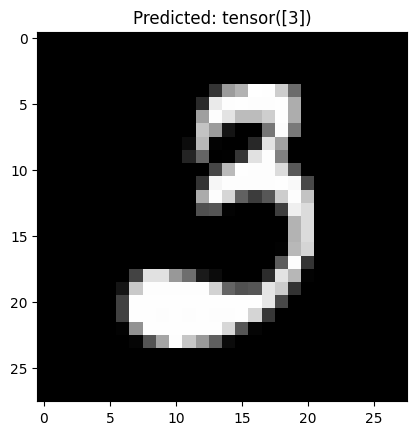

In [ ]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
  image = testloader.dataset.test_data[index].numpy()
  plt.imshow(image, cmap='gray')
  y_pred = net(torch.Tensor(image).view(1, 1, 28, 28))
  _, predicted = torch.max(y_pred, 1)
  plt.title(f'Predicted: {predicted}')
visualize_result(i)

# Часть 2
Посмотрим, насколько хорошо CNN будут предсказывать классы на более
сложном датасете картинок - CIFAR10.


## Подготовка данных

In [ ]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 103250013.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Выведем произвольное изображение для примера

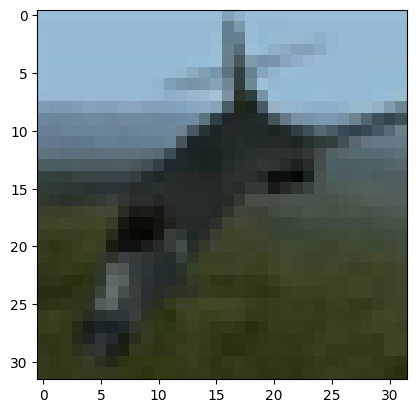

In [ ]:
i = np.random.randint(low=0, high=50000)
plt.imshow(trainloader.dataset.data[i]);

##Свёрточная нейросеть для предсказания на CIFAR10

In [ ]:
class SimpleConvNet(torch.nn.Module):
  def __init__(self):
# вызов конструктора класса nn.Module()
    super(SimpleConvNet, self).__init__()
# feature extractor
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
# classificator
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
# print(x.shape)
    x = x.view(-1, 5 * 5 * 16)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

###Обучение сети

In [ ]:
net = SimpleConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# итерируемся
for epoch in tqdm_notebook(range(3)):
  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)):
    # так получаем текущий батч
    X_batch, y_batch = batch
# обнуляем веса
    optimizer.zero_grad()
# forward + backward + optimize
    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
# выводим качество каждые 2000 батчей
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Обучение закончено')

<ipython-input-19-60d24f87ce6c>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(3)):


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-19-60d24f87ce6c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.032
[1,  4000] loss: 1.804
[1,  6000] loss: 1.694
[1,  8000] loss: 1.612
[1, 10000] loss: 1.580
[1, 12000] loss: 1.575


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.528
[2,  4000] loss: 1.503
[2,  6000] loss: 1.496
[2,  8000] loss: 1.459
[2, 10000] loss: 1.455
[2, 12000] loss: 1.426


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.384
[3,  4000] loss: 1.383
[3,  6000] loss: 1.392
[3,  8000] loss: 1.381
[3, 10000] loss: 1.364
[3, 12000] loss: 1.378
Обучение закончено


###Тестирование полученной сети

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
  classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 60 %
Accuracy of  bird : 46 %
Accuracy of   cat : 19 %
Accuracy of  deer : 51 %
Accuracy of   dog : 44 %
Accuracy of  frog : 61 %
Accuracy of horse : 53 %
Accuracy of  ship : 67 %
Accuracy of truck : 59 %


###Визуализация полученных результатов

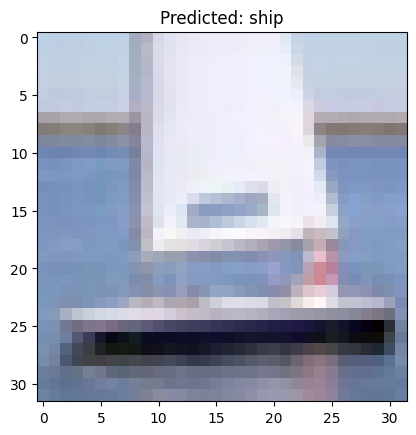

In [ ]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
  image = testloader.dataset.data[index]

  plt.imshow(image)
  image = transform(image) # не забудем отмасштабировать!
  y_pred = net(image.view(1, 3, 32, 32))
  _, predicted = torch.max(y_pred, 1)
  plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')
visualize_result(i)

## Улучшенная архитектура

Улучшим свёрточную нейросеть: поэкспериментируем с архитектурой (количество
слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а,
количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в
"Компоненты нейросети".

In [ ]:
class BetterConvNet(nn.Module):
 def __init__(self):
 # вызов конструктора класса nn.Module()
  super(BetterConvNet, self).__init__()
  self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
  self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
  self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
  self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
  self.fc1 = nn.Linear(3 * 3 * 32, 120)
  self.fc2 = nn.Linear(120, 84)
  self.fc3 = nn.Linear(84, 10)
 def forward(self, x):
  x = self.pool(F.relu(self.conv1(x)))
  x = self.pool(self.conv3(F.relu(self.conv2(x))))
# print(x.shape)
  x = x.view(-1, 3 * 3 * 32)
  x = F.relu(self.fc1(x))
  x = F.relu(self.fc2(x))
  x = self.fc3(x)
  return x

Обучение

In [ ]:
from tqdm import tqdm_notebook
net = BetterConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# итерируемся
for epoch in tqdm_notebook(range(5)):
 running_loss = 0.0
 for i, batch in enumerate(tqdm_notebook(trainloader)):
# так получаем текущий батч
  X_batch, y_batch = batch
 # обнуляем веса
  optimizer.zero_grad()
 # forward + backward + optimize
  y_pred = net(X_batch)
  loss = loss_fn(y_pred, y_batch)
  loss.backward()
  optimizer.step()
 # выведем текущий loss
  running_loss += loss.item()
 # выведем качество каждые 2000 батчей
  if i % 2000 == 1999:
    print('[%d, %5d] loss: %.3f' %
    (epoch + 1, i + 1, running_loss / 2000))
    running_loss = 0.0

print('Обучение закончено')

<ipython-input-24-fc325eb76130>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-24-fc325eb76130>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.983
[1,  4000] loss: 1.715
[1,  6000] loss: 1.622
[1,  8000] loss: 1.568
[1, 10000] loss: 1.539
[1, 12000] loss: 1.505


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.447
[2,  4000] loss: 1.423
[2,  6000] loss: 1.422
[2,  8000] loss: 1.407
[2, 10000] loss: 1.394
[2, 12000] loss: 1.375


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.338
[3,  4000] loss: 1.340
[3,  6000] loss: 1.358
[3,  8000] loss: 1.331
[3, 10000] loss: 1.325
[3, 12000] loss: 1.318


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.282
[4,  4000] loss: 1.260
[4,  6000] loss: 1.255
[4,  8000] loss: 1.280
[4, 10000] loss: 1.273
[4, 12000] loss: 1.266


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.230
[5,  4000] loss: 1.209
[5,  6000] loss: 1.234
[5,  8000] loss: 1.228
[5, 10000] loss: 1.247
[5, 12000] loss: 1.230
Обучение закончено


###Тестирование

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
 for data in testloader:
  images, labels = data
  y_pred = net(images)
  _, predicted = torch.max(y_pred, 1)
  c = (predicted == labels).squeeze()
  for i in range(4):
    label = labels[i]
    class_correct[label] += c[i].item()
    class_total[label] += 1

for i in range(10):
 print('Accuracy of %5s : %2d %%' % (
 classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 70 %
Accuracy of  bird : 44 %
Accuracy of   cat : 43 %
Accuracy of  deer : 45 %
Accuracy of   dog : 32 %
Accuracy of  frog : 55 %
Accuracy of horse : 55 %
Accuracy of  ship : 82 %
Accuracy of truck : 64 %


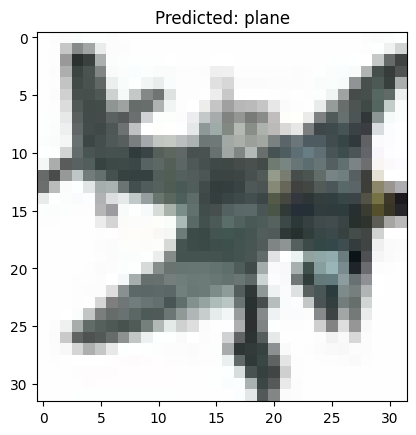

In [ ]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
 image = testloader.dataset.data[index]
 plt.imshow(image)
 image = transform(image)
 y_pred = net(image.view(1, 3, 32, 32))
 _, predicted = torch.max(y_pred, 1)
 plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')
visualize_result(i)

## Улучшенная нейросеть

In [ ]:
class StrongConvNet(nn.Module):
  def __init__(self):
# вызов конструктора класса nn.Module()
    super(StrongConvNet, self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(p=0.2)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(8)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1)
    self.bn2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
    self.bn3 = nn.BatchNorm2d(16)
    self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    self.bn5 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(4 * 4 * 32, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.pool(x)
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.pool(x)
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))
# print(x.shape)
    x = x.view(-1, 4 * 4 * 32)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

###Обучение

In [ ]:
from tqdm import tqdm_notebook
from torch.optim import lr_scheduler
net = StrongConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
learning_rate = 1e-3
# !!! новый момент - динамически изменяем LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
for epoch in tqdm_notebook(range(num_epochs)):
  scheduler.step()
  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)):
    X_batch, y_batch = batch
    optimizer.zero_grad()
    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
print('Обучение закончено')

<ipython-input-31-c38dec0f19ef>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-31-c38dec0f19ef>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.866
[1,  4000] loss: 1.633
[1,  6000] loss: 1.551
[1,  8000] loss: 1.490
[1, 10000] loss: 1.423
[1, 12000] loss: 1.392


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.286
[2,  4000] loss: 1.260
[2,  6000] loss: 1.228
[2,  8000] loss: 1.224
[2, 10000] loss: 1.200
[2, 12000] loss: 1.198


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.078
[3,  4000] loss: 1.076
[3,  6000] loss: 1.073
[3,  8000] loss: 1.058
[3, 10000] loss: 1.057
[3, 12000] loss: 1.070


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 0.988
[4,  4000] loss: 0.950
[4,  6000] loss: 0.980
[4,  8000] loss: 0.961
[4, 10000] loss: 0.940
[4, 12000] loss: 0.943


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 0.923
[5,  4000] loss: 0.920
[5,  6000] loss: 0.924
[5,  8000] loss: 0.924
[5, 10000] loss: 0.949
[5, 12000] loss: 0.914
Обучение закончено


### Тестирование

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 79 %
Accuracy of  bird : 46 %
Accuracy of   cat : 40 %
Accuracy of  deer : 60 %
Accuracy of   dog : 51 %
Accuracy of  frog : 71 %
Accuracy of horse : 67 %
Accuracy of  ship : 75 %
Accuracy of truck : 72 %


### Визуализация работы

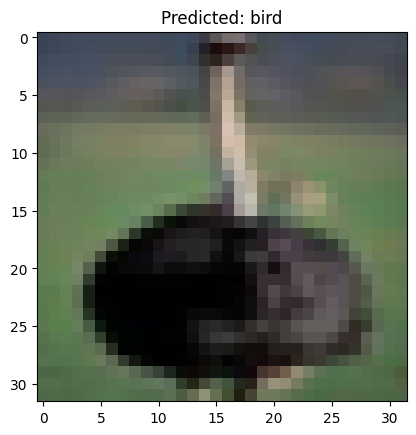

In [ ]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
  image = testloader.dataset.data[index]
  plt.imshow(image)
  image = transform(image) # не забудем отмасштабировать!
  y_pred = net(image.view(1, 3, 32, 32))
  _, predicted = torch.max(y_pred, 1)
  plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

# Часть 3

Распознавание датасета Fashion MINIST

## Сверточная нейронная сеть Fashion MINIST

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
transform = transforms.Compose(
[transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
shuffle=False, num_workers=2)

classes = ('T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle boot')

100%|██████████| 26421880/26421880 [00:01<00:00, 13993388.64it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271101.30it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5012826.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5473327.50it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Проанализируем dataset

In [26]:
trainset.data.shape


torch.Size([60000, 28, 28])

In [27]:
testset.data.shape

torch.Size([10000, 28, 28])

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


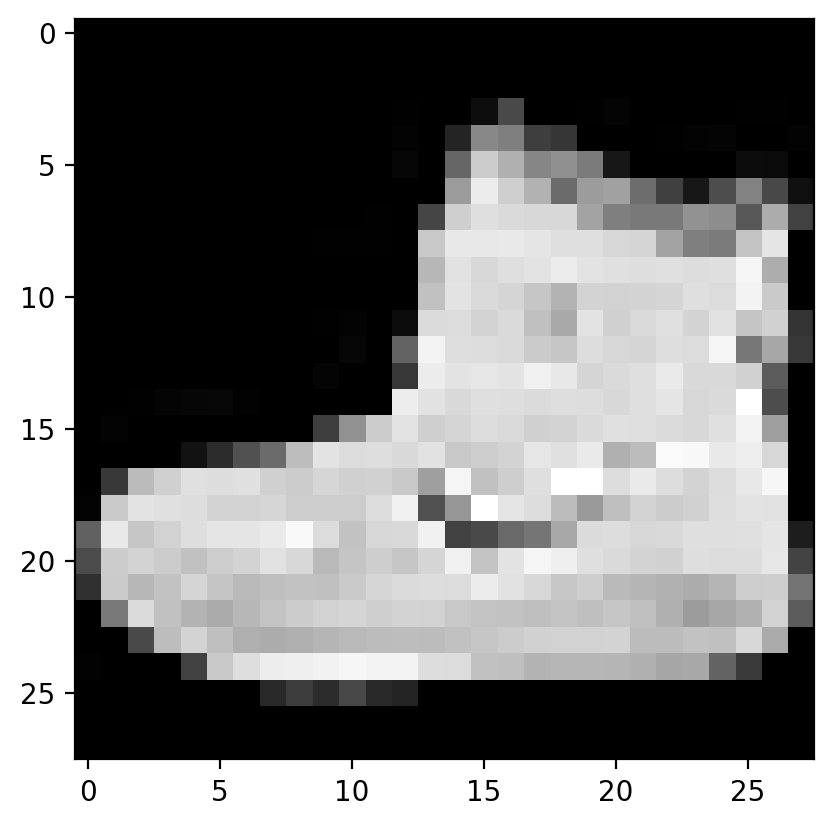

In [28]:
numpy_img = trainloader.dataset.train_data[0].numpy()
numpy_img.shape
plt.imshow(numpy_img);
plt.imshow(numpy_img, cmap='gray');

In [29]:
def printFashionStaff(i):
  plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

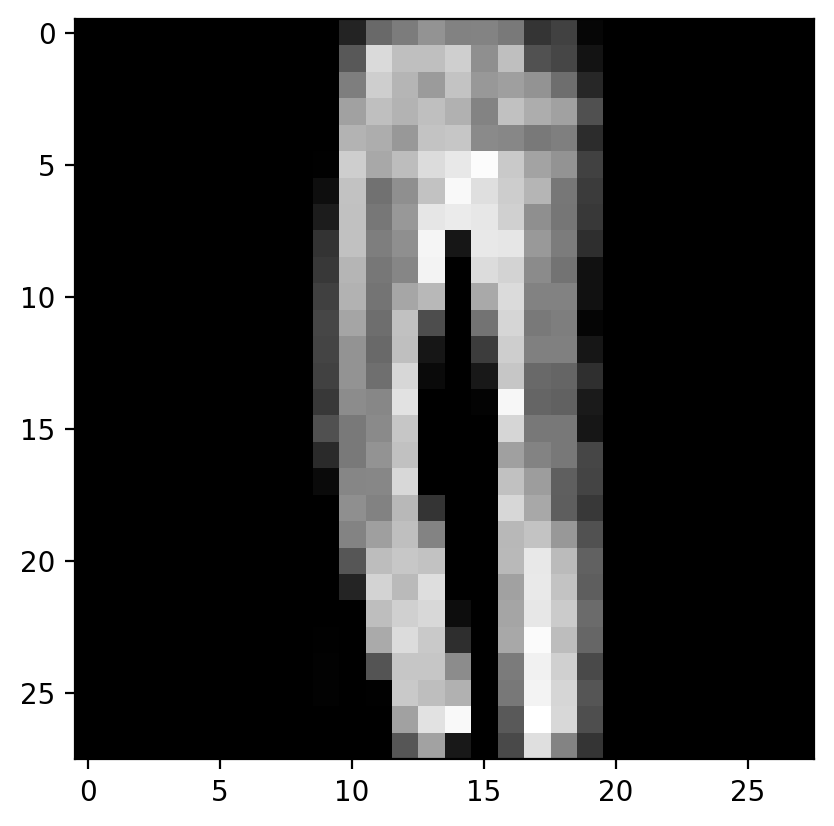

In [30]:
i = np.random.randint(low=0, high=60000)
printFashionStaff(i)

##Модель

In [31]:
# Заметьте: класс наследуется от nn.Module
class SimpleConvNet(nn.Module):
  def __init__(self):
# вызов конструктора предка
    super(SimpleConvNet, self).__init__()
# необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
# которую будем подавать в сеть, больше ничего
# про входящие картинки знать не нужно
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(4 * 4 * 16, 120) # !!!
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #print(x.shape)
    #return
    # torch.Size([4, 16, 4, 4])
    x = x.view(-1, 4 * 4 * 16) # !!! Это – размерность тензора перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Код обучения слоя

In [32]:
from tqdm import tqdm_notebook
# объявляем сеть
net = SimpleConvNet()
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()
# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
# итерируемся
for epoch in tqdm_notebook(range(3)):
  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)):
    # так получаем текущий батч
    X_batch, y_batch = batch
# обнуляем веса
    optimizer.zero_grad()
    # forward + backward + optimize
    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
# выведем текущий loss
    running_loss += loss.item()
    # выведем качество каждые 2000 батчей
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      train_losses.append(running_loss);
      running_loss = 0.0

print('Обучение закончено')

<ipython-input-32-af5b91c22e95>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(3)):


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-32-af5b91c22e95>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.272
[1,  4000] loss: 0.792
[1,  6000] loss: 0.729
[1,  8000] loss: 0.682
[1, 10000] loss: 0.658
[1, 12000] loss: 0.631
[1, 14000] loss: 0.607


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.575
[2,  4000] loss: 0.559
[2,  6000] loss: 0.547
[2,  8000] loss: 0.533
[2, 10000] loss: 0.534
[2, 12000] loss: 0.513
[2, 14000] loss: 0.511


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.479
[3,  4000] loss: 0.462
[3,  6000] loss: 0.488
[3,  8000] loss: 0.455
[3, 10000] loss: 0.455
[3, 12000] loss: 0.456
[3, 14000] loss: 0.439
Обучение закончено


### Визуализация функции потерть

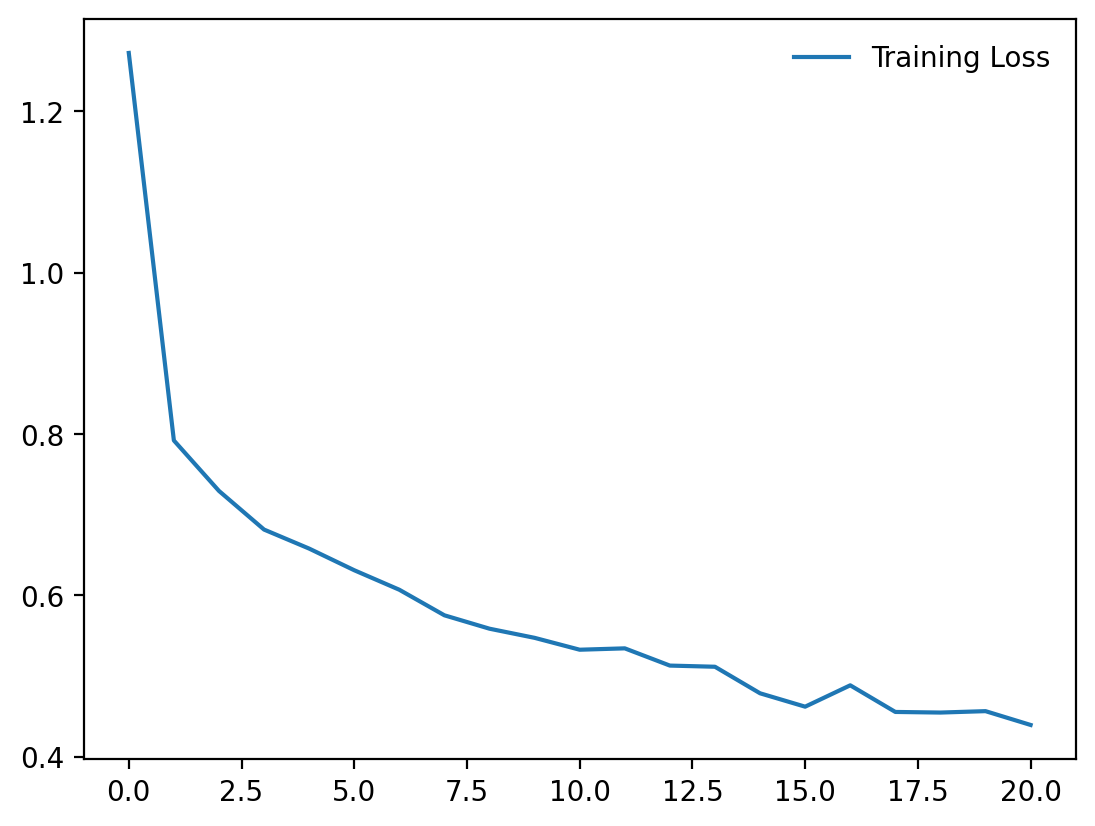

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
loss_cnn = []
for i in train_losses:
  i = i / 2000;
  loss_cnn.append(i);
plt.plot(loss_cnn, label='Training Loss')
plt.legend(frameon=False)

###Тестирование модели

In [34]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
  classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 84 %
Accuracy of Trouser : 95 %
Accuracy of Pullover : 67 %
Accuracy of Dress : 82 %
Accuracy of  Coat : 72 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 59 %
Accuracy of Sneaker : 90 %
Accuracy of   Bag : 93 %
Accuracy of Ankle boot : 92 %


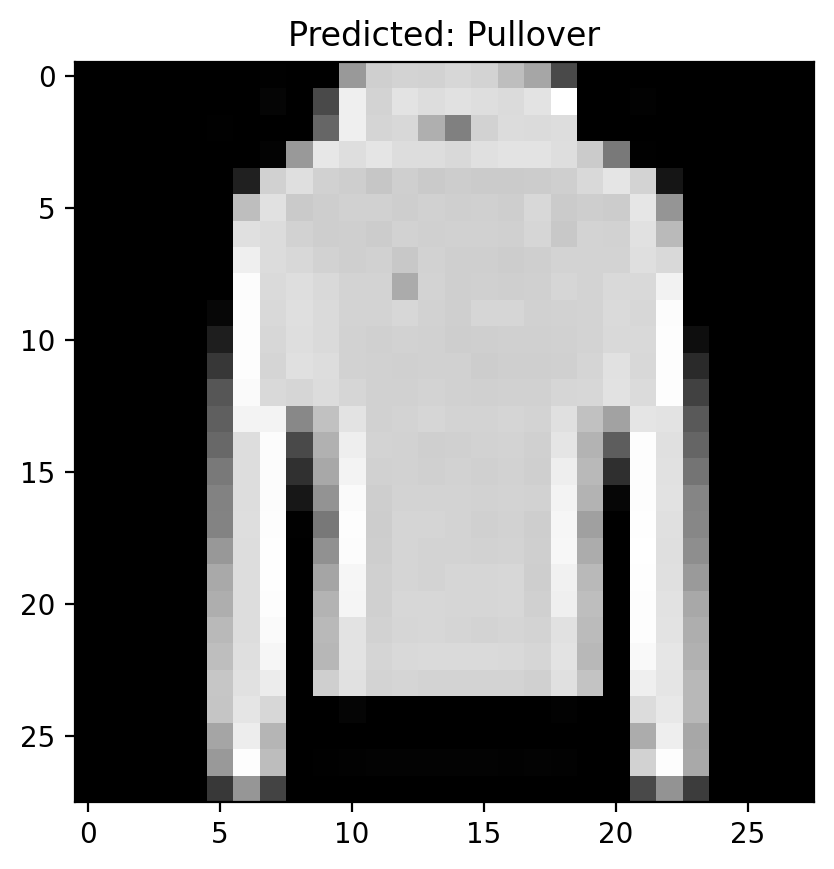

In [35]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
  image = testloader.dataset.test_data[index].numpy()
  plt.imshow(image, cmap='gray')
  y_pred = net(torch.Tensor(image).view(1, 1, 28, 28))
  _, predicted = torch.max(y_pred, 1)
  plt.title(f'Predicted: {classes[predicted]}')
visualize_result(i)

## Многослойнный перцептрон

In [52]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
def printNum(i):
  plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


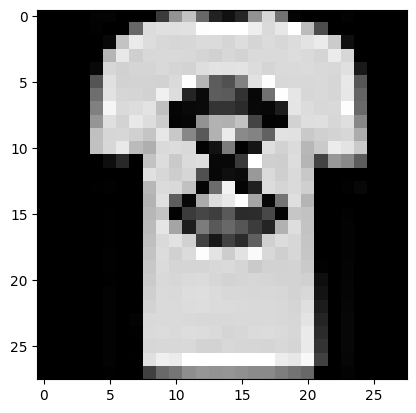

In [5]:
i = np.random.randint(low=0, high=60000)
printNum(i)

###Модель

In [54]:

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):

        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

Задаем метод оптимизации и функцию потерь

In [55]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

### Обучение

In [56]:
epochs = 10
loss_=[]
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        loss_.append(running_loss/len(trainloader))

Training loss: 0.5145997415060428
Training loss: 0.39081429069770424
Training loss: 0.3538487118158513
Training loss: 0.3298326044686949
Training loss: 0.3168069125254398
Training loss: 0.3007793113875237
Training loss: 0.2935739534019407
Training loss: 0.2821838100994828
Training loss: 0.2757176356370261
Training loss: 0.2641026682691025


### Визуализация функции потерь

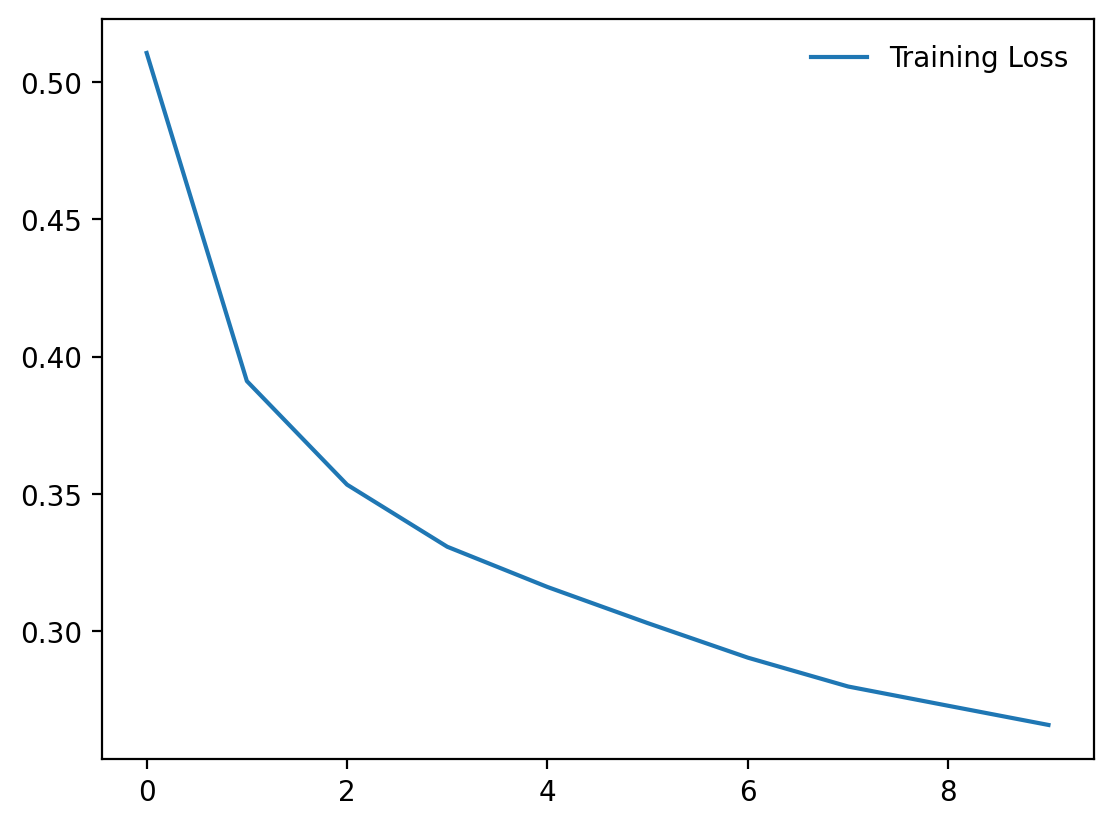

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(loss_, label='Training Loss')
plt.legend(frameon=False)

### Тестирование

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    y_pred = model(images)
    _, predicted = torch.max(y_pred, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
  classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 78 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 70 %
Accuracy of Dress : 90 %
Accuracy of  Coat : 87 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 79 %
Accuracy of Sneaker : 98 %
Accuracy of   Bag : 98 %
Accuracy of Ankle Boot : 92 %


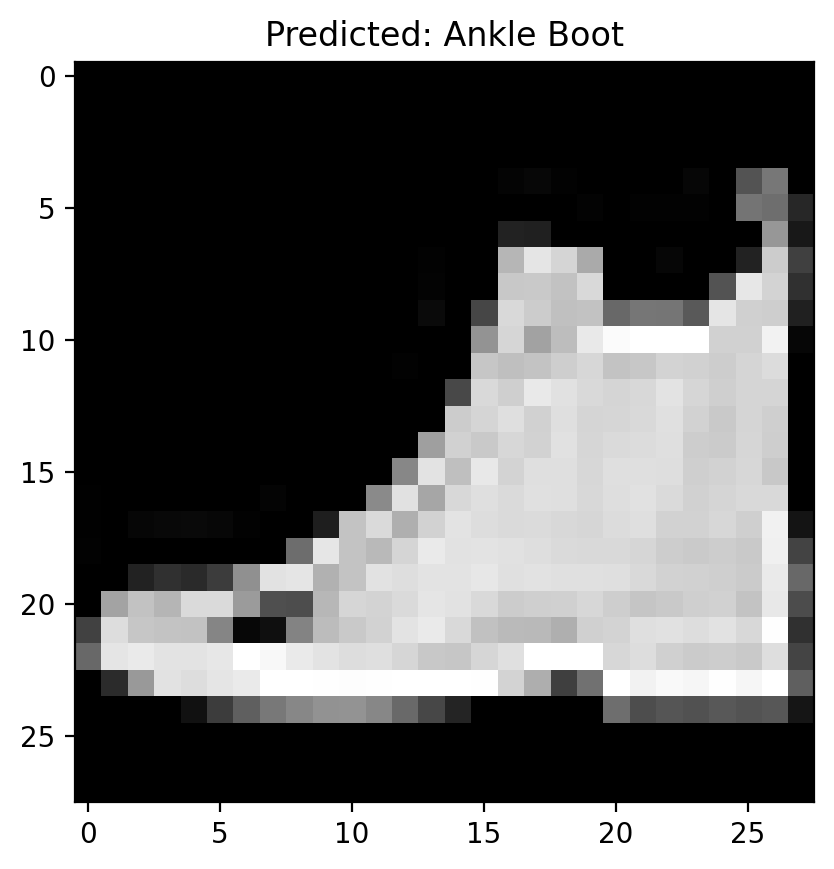

In [23]:
i = np.random.randint(low=0, high=10000)
def visualize_result(index):
  image = testloader.dataset.test_data[index].numpy()
  plt.imshow(image, cmap='gray')
  y_pred = model(torch.Tensor(image).view(1, 1, 28, 28))
  _, predicted = torch.max(y_pred, 1)
  plt.title(f'Predicted: {classes[predicted]}')
visualize_result(i)

https://www.kaggle.com/code/nikolaosjp/mlp-for-f-mnist-classification

https://notebook.community/Diyago/Machine-Learning-scripts/DEEP%20LEARNING/Pytorch%20from%20scratch/MLP/Part%204%20-%20Fashion-MNIST%20(Solution)